In [1]:
import scanpy as sc
import os
import seaborn as sns
import pandas as pd
import numpy as np
import anndata as ad
import bbknn
import muon as mu
from muon import atac as ac
import pyranges as pr

import matplotlib
import matplotlib.pyplot as plt

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/sorted_nearest/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Loading data

In [2]:
data_dir = "/faststorage/project/projectsInBioinformatics/data/PRJNA1177103_aws/SRR31097968_split/SRR31097968/outs/"
data_set = "OA2"
mdata = mu.read_10x_h5(os.path.join(data_dir, "filtered_peak_bc_matrix.h5"))
atac = mdata.mod['atac']
ac.tl.locate_fragments(atac, fragments=os.path.join(data_dir, "fragments.tsv.gz"))
ac.tl.add_peak_annotation(atac, annotation=os.path.join(data_dir, "peak_annotation.tsv"))
atac.obs['label'] = data_set

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/muon/_atac/tools.py:118: FutureWarning: Setting an

In [3]:
atac

AnnData object with n_obs × n_vars = 51390 × 91460
    obs: 'label'
    var: 'gene_ids', 'feature_types', 'derivation', 'genome'
    uns: 'files', 'atac'

In [4]:
atac.layers["raw_counts"] = atac.X.copy()

# Quality control

In [5]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

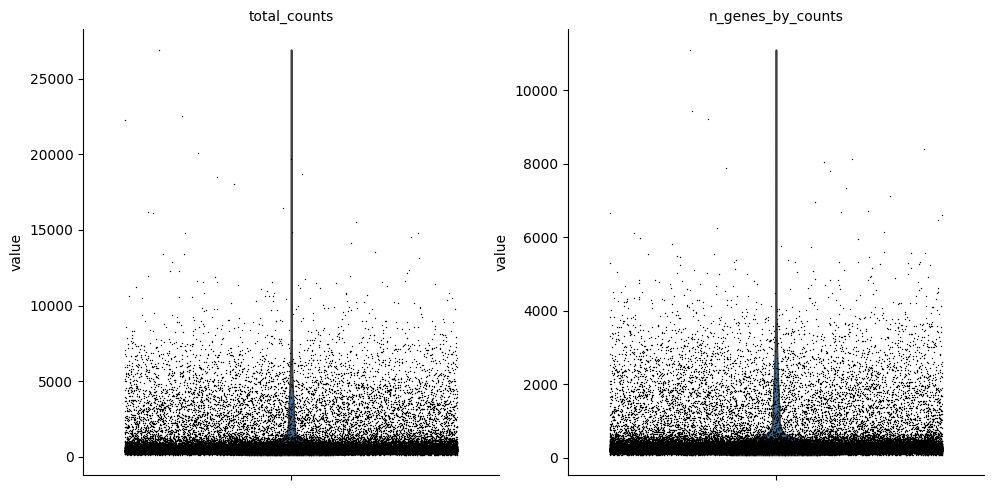

In [6]:
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

In [7]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 500) & (x <= 2000))
mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 100) & (x <= 5000))

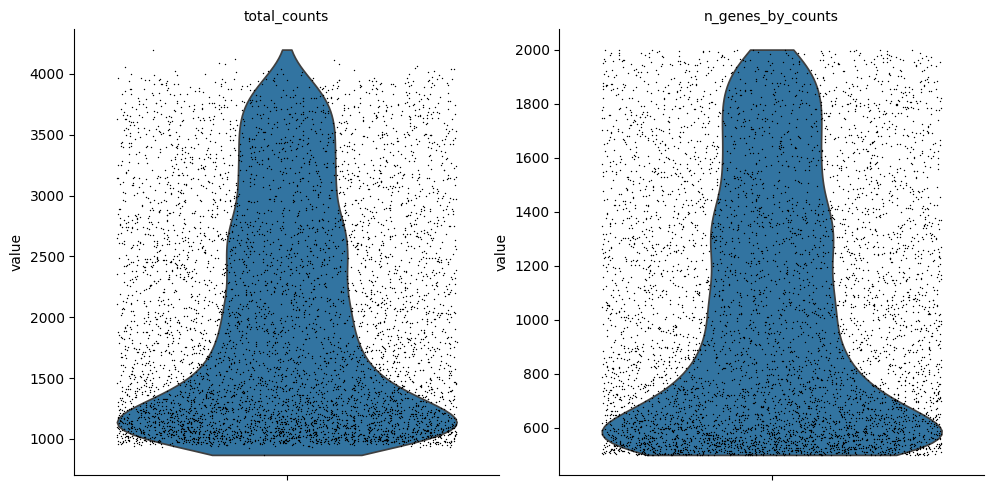

In [8]:
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

In [9]:
atac.layers['filtered'] = atac.X.copy()

In [10]:
ac.tl.nucleosome_signal(atac)

Reading Fragments: 100%|█████████████████████████████████████| 57310000/57310000 [03:02<00:00, 314759.31it/s]


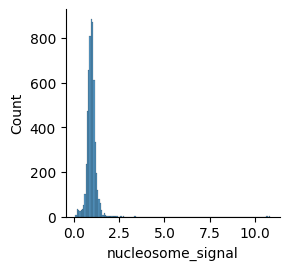

In [11]:
mu.pl.histogram(atac, "nucleosome_signal", kde=False)

Fetching Regions...: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


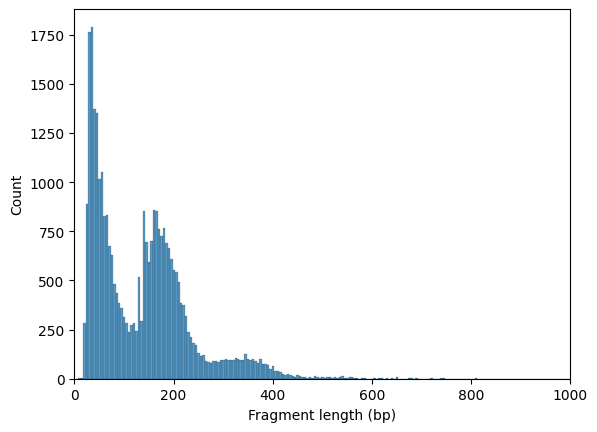

In [12]:
ac.pl.fragment_histogram(atac)

# Normalisation

In [13]:
ac.pp.tfidf(atac, scale_factor=1e4)

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/muon/_atac/preproc.py:106: RuntimeWarning: divide by zero encountered in divide
  idf = np.asarray(adata.shape[0] / counts.sum(axis=0)).reshape(-1)


In [14]:
atac.layers["normalised"] = atac.X

# Feature selection

In [15]:
ac.tl.lsi(atac)

# Removing first component per recommendation as it is usually associated with cell count and/or number of peaks
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:,1:]
atac.varm["LSI"] = atac.varm["LSI"][:,1:]
atac.uns["lsi"]["stdev"] = atac.uns["lsi"]["stdev"][1:]

In [16]:
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30)

# Gene activity matrix

In [17]:
gtf = pr.read_gtf("/faststorage/project/projectsInBioinformatics/data/refdata-cellranger-arc-GRCh38-2024-A/genes/genes.gtf.gz")
genes = gtf[gtf.Feature == "gene"]
features = genes.as_df()[["Chromosome", "Start", "End", "gene_name"]]
features.columns = ["chrom", "start", "end", "gene_name"]
features = features[features["chrom"] != "chrM"]
features = features.set_index("gene_name")
features

,chrom,start,end
gene_name,,,
ENSG00000278704,GL000009.2,56139,58376
ENSG00000277400,GL000194.1,53589,115018
MAFIP,GL000194.1,53593,115055
ENSG00000276256,GL000195.1,42938,49164
ENSG00000277630,GL000213.1,108006,139659
...,...,...,...
DAZ3,chrY,24763068,24813492
BPY2C,chrY,25030900,25062548
TTTY4C,chrY,25063082,25099892


In [18]:
atac_ga = ac.tl.count_fragments_features(atac, features = features)

/tmp/11354000/ipykernel_3468068/3241082652.py:1: FutureWarning: From v0.2, by default, unique fragments will be counted instead of reads. See muon#110 for details.
  atac_ga = ac.tl.count_fragments_features(atac, features = features)
100%|██████████████████████████████████████████████████████████████████| 38593/38593 [08:44<00:00, 73.53it/s]
/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [19]:
atac_ga.layers['standard'] = atac_ga.X

In [20]:
atac_ga.obs["celltype_leiden"] = "Unknown"

# Preparing Gene Activity matrix and RNA data

In [21]:
atac_ga.X = atac_ga.layers["standard"].copy()
atac_ga.obs_names = [f"ATAC_{x}" for x in atac_ga.obs_names]
sc.pp.normalize_total(atac_ga, target_sum=1e4)
sc.pp.log1p(atac_ga)
sc.pp.scale(atac_ga)
sc.pp.pca(atac_ga, random_state=123)
atac_ga.var_names_make_unique()

/home/jool/miniforge3/envs/torch/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [22]:
rna = sc.read("/faststorage/project/projectsInBioinformatics/workspaces/johan/results/combined_rna.h5ad")

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [23]:
rna.X = rna.layers['raw_counts'].copy()
rna.obs_names = [f"RNA_{x}" for x in rna.obs_names]
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.pp.pca(rna, random_state=123)
rna.var_names_make_unique()

/home/jool/miniforge3/envs/torch/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [24]:
merged = ad.concat([rna, atac_ga], axis = "obs", join = "inner", label="technology", keys=["RNA", "ATAC"])

/home/jool/miniforge3/envs/torch/lib/python3.13/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Project ATAC data onto RNA and assign celltype on neighbours

In [25]:
sc.external.pp.harmony_integrate(merged, key="technology")

2025-11-07 16:35:29,132 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-07 16:35:34,116 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-07 16:35:34,173 - harmonypy - INFO - Iteration 1 of 10
2025-11-07 16:35:37,464 - harmonypy - INFO - Iteration 2 of 10
2025-11-07 16:35:40,726 - harmonypy - INFO - Converged after 2 iterations


In [26]:
merged.obsm["X_pca"]= merged.obsm["X_pca_harmony"].copy()

In [27]:
bbknn.bbknn(merged, batch_key="technology", neighbors_within_batch=20)

In [28]:
sc.tl.umap(merged, random_state = 123)

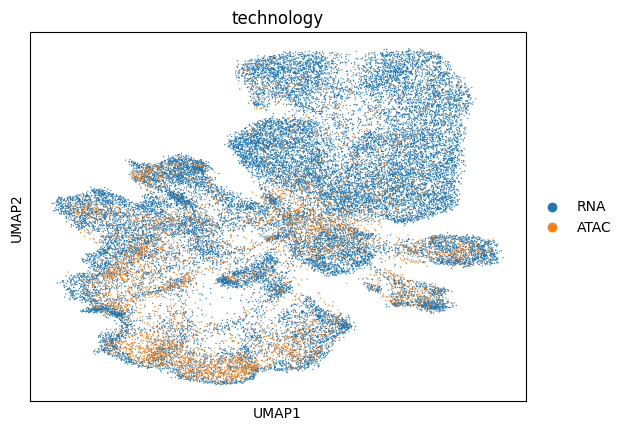

In [29]:
sc.pl.umap(merged, color=["technology"])

# Ingest

In [30]:
from scipy import sparse
from collections import Counter

In [31]:
# Get indices for RNA and ATAC cells
rna_mask = merged.obs["technology"] == "RNA"
atac_mask = merged.obs["technology"] == "ATAC"

# Get the connectivity matrix (neighbors graph)
connectivities = merged.obsp['connectivities']

# For each ATAC cell, find its RNA neighbors and assign consensus cell type
for atac_idx in np.where(atac_mask)[0]:
    # Get neighbors of this ATAC cell
    neighbors_row = connectivities[atac_idx].toarray().flatten()
    neighbor_indices = np.where(neighbors_row > 0)[0]
    
    # Filter to only RNA neighbors
    rna_neighbor_indices = neighbor_indices[rna_mask[neighbor_indices]]
    
    if len(rna_neighbor_indices) > 0:
        # Get cell types of RNA neighbors
        rna_neighbor_celltypes = merged.obs.iloc[rna_neighbor_indices]["celltype_leiden"].values
        
        # Find most common cell type (consensus)
        consensus_celltype = Counter(rna_neighbor_celltypes).most_common(1)[0][0]
        
        # Assign to ATAC cell
        merged.obs.loc[merged.obs.index[atac_idx], "celltype_leiden"] = consensus_celltype

# Some cells still unknown - distance too big from RNA cells - doing a second pass using also renamed cells from ATAC
unknows_present = True
while unknows_present:
    
    # Find ATAC cells still labeled as "Unknown"
    unknown_atac_indices = merged.obs[
        (merged.obs["technology"] == "ATAC") & (merged.obs["celltype_leiden"] == "Unknown")
    ].index
    
    for idx in unknown_atac_indices:
        row_idx = merged.obs.index.get_loc(idx)
        neighbors_row = connectivities[row_idx].toarray().flatten()
        neighbor_indices = np.where(neighbors_row > 0)[0]
        if len(neighbor_indices) > 0:
            neighbor_celltypes = merged.obs.iloc[neighbor_indices]["celltype_leiden"]
            # Exclude "Unknown" from consensus
            neighbor_celltypes = neighbor_celltypes[neighbor_celltypes != "Unknown"]
            if len(neighbor_celltypes) > 0:
                consensus = Counter(neighbor_celltypes).most_common(1)[0][0]
                merged.obs.at[idx, "celltype_leiden"] = consensus
    if len(merged.obs[(merged.obs["technology"] == "ATAC") & (merged.obs["celltype_leiden"] == "Unknown")].index) > 0:
        unknows_present = True
    else: 
        unknows_present = False

/tmp/11354000/ipykernel_3468068/963089664.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rna_neighbor_indices = neighbor_indices[rna_mask[neighbor_indices]]
/tmp/11354000/ipykernel_3468068/963089664.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rna_neighbor_indices = neighbor_indices[rna_mask[neighbor_indices]]
/tmp/11354000/ipykernel_3468068/963089664.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rna_neighbor_in

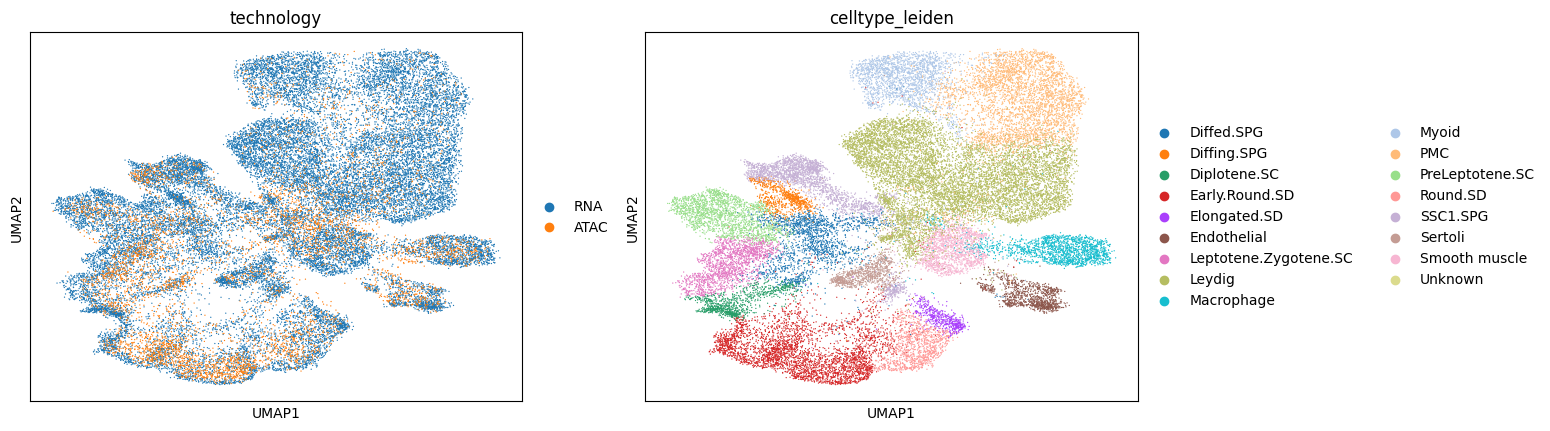

In [32]:
sc.pl.umap(merged, color=["technology","celltype_leiden"], ncols=2)

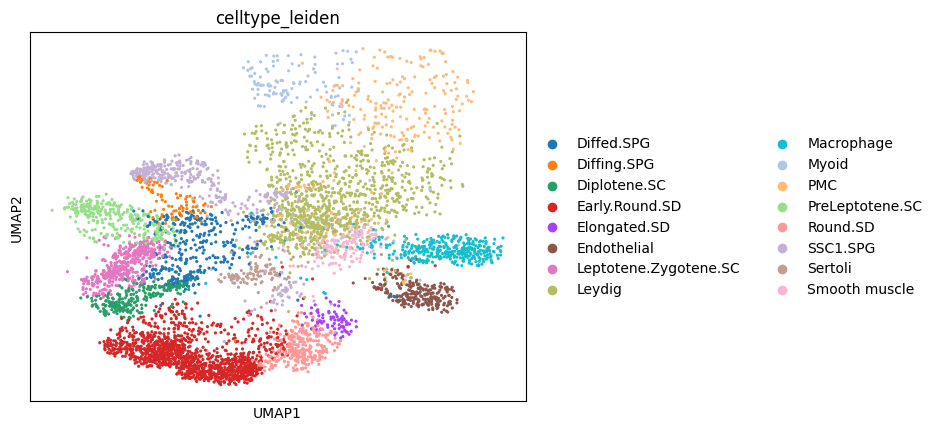

In [33]:
sc.pl.umap(merged[merged.obs["technology"] == "ATAC"], color=["celltype_leiden"])

In [34]:
atac_ga.obs["celltype_leiden"] = merged[merged.obs.technology == "ATAC"].obs["celltype_leiden"]

In [35]:
atac.obs["celltype_leiden"] = merged[merged.obs.technology == "ATAC"].obs["celltype_leiden"]

# Saving data to disk

In [36]:
save_dir = "/faststorage/project/projectsInBioinformatics/workspaces/johan/results/"
atac_ga.write(os.path.join(save_dir, f"{data_set}_atac_ga.h5ad"))
atac.write(os.path.join(save_dir, f"{data_set}_atac_processed.h5ad"))